# Feature Analysis

In [1]:
import pandas as pd

In [2]:
filename1 = 'pionminus'
filename2 = 'electron'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

In [3]:
data1 = pd.read_csv(filepath+f'{filename1}.csv')
data1.loc[data1['phi0'] > -99, 'phi0'] = 0
data2 = pd.read_csv(filepath+f'{filename2}.csv')
data2.loc[data2['phi0'] > -99, 'phi0'] = 1

In [4]:
data = pd.concat([data1,data2], sort=False)
data = data.sample(frac = 1)
data['phi0'] = data['phi0'].astype('int32')
data['centrality'] = data['centrality'].astype('int32')
data['zvertex'] = data['zvertex'].astype('float16')
data['pt'] = data['pt'].astype('float16')
data['e/p'] = data['e/p'].astype('float16')
data['n0'] = data['n0'].astype('int32')
data['disp'] = data['disp'].astype('float16')
data['chi2'] = data['chi2'].astype('float16')
data['npe0'] = data['npe0'].astype('int32')
data['prob'] = data['prob'].astype('float16')
data.head()

,centrality,zvertex,pt,e/p,n0,disp,chi2,npe0,prob,phi0
100380,66,-1.158203,0.659180,0.876953,4,3.683594,107.812500,13,0.419678,1
1142959,52,8.406250,0.743164,0.901367,4,0.631836,29.265625,8,0.959961,1
212321,10,3.291016,0.437256,0.973145,1,5.882812,63.093750,0,0.280762,0
512297,45,4.277344,0.348145,0.858398,7,1.248047,33.781250,13,0.915527,1
758672,1,3.564453,1.102539,0.895020,3,5.726562,12.875000,5,0.435303,1


In [5]:
print(data.size, data.shape, data1.shape, data2.shape)

20743310 (2074331, 10) (348012, 10) (1726319, 10)


In [6]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)



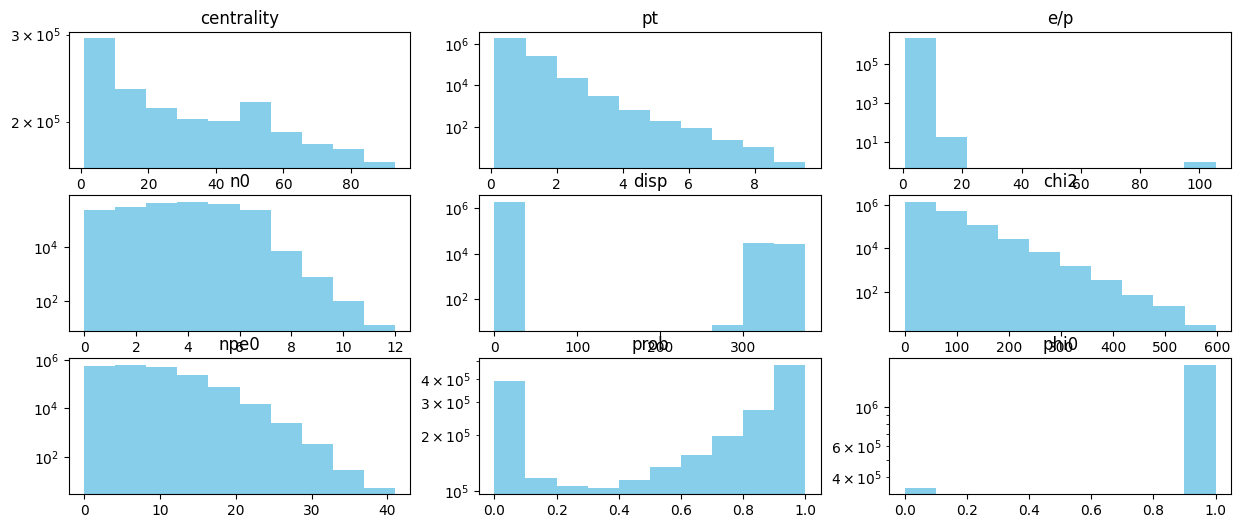

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
from sklearn.preprocessing import OneHotEncoder

def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # удаляем impressions
    data = data.drop('impressions', axis = 1)
    
    # создаем фичи от времени
    data.date_time = pd.to_datetime(data.date_time)
    data['day'] = data['date_time'].dt.weekday
    data['hour'] = data['date_time'].dt.hour
    
    # строим графики зависимости количества кликов от дня недели и часа
    data[data['clicks'] > 0].sort_values(by = ['day']).groupby(['day'])['clicks'].sum().plot.barh(title='Clicks by weekday')
    plt.show()
    data[data['clicks'] > 0].sort_values(by = ['hour']).groupby(['hour'])['clicks'].sum().plot.barh(title='Clicks by hour')

    # добавляем интерсекции между часом и днем недели 
    data['hour_day'] = data['day'].astype(str) + ' ' + data['hour'].astype(str)
    data['hour_day'] = pd.factorize(data['hour_day'])[0]
    
    # выделяем редкие zone id в категорию -1
    zone_id_counts = data['zone_id'].value_counts()
    idxs = zone_id_counts[zone_id_counts < 10].index
    
    data.loc[data['zone_id'].isin(idxs), 'zone_id'] = -1
    
    # выделяем редкие os_id в категорию 7
    data.loc[data['os_id'] > 7, 'os_id'] = 7
    
    # преобразовываем campaign clicks в бинарную фичу
    data['before_clicks'] = data['campaign_clicks'] > 0
    data['before_clicks'] = data['before_clicks'].astype('int64')
    
    # делим выборку на train и test
    data = data.sort_values(by='date_time', ignore_index=True)
    cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    y = data['clicks']
    data = data.drop(columns = ['banner_id', 'clicks', 'campaign_clicks', 'date_time'])
    data_train, data_test = data.iloc[:cut_off_test, :], data.iloc[cut_off_test:, :]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    enc.fit(data_train)
    transformed_train = enc.transform(data_train)
    transformed_test = enc.transform(data_test)
    
    return transformed_train, transformed_test, y_train, y_test,cut_off_val

In [10]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [11]:
transformed_train_all, transformed_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

691443 1382888


In [12]:
transformed_test

,centrality,pt,e/p,n0,disp,chi2,npe0,prob
53580,16,0.747559,0.985840,2,3.792969,25.390625,1,0.000018
910686,60,1.391602,0.958496,5,0.961914,35.812500,16,0.607910
230082,61,0.447266,0.737793,3,5.753906,128.000000,7,0.739746
526007,71,0.457520,1.012695,2,2.777344,4.148438,8,0.786133
95125,48,1.389648,0.665039,1,8.421875,50.343750,0,0.994629
...,...,...,...,...,...,...,...,...
414326,26,0.645996,0.857910,4,0.813965,69.437500,7,0.489990
1628047,50,0.398926,0.867188,5,2.333984,55.593750,10,0.577637
252618,7,0.488525,1.104492,3,2.599609,42.843750,9,0.106873
40882,81,0.555664,0.830078,6,0.264160,18.656250,19,0.177612


In [13]:
transformed_train, transformed_val = transformed_train_all[:cut_off_val], transformed_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, f1_score

In [15]:
def create_model(C):
    clf = LogisticRegression(solver='newton-cholesky', max_iter=10000, C=C, verbose=1)
    return clf

Возьмем логистическую регрессию, в качестве солвера берем newton-cholesky, так как в документации sklearn сказано, что он лучше работает с one-hot-encoded фичами.

# Cross Validation

In [16]:
def cv(data_train: pd.DataFrame, data_val, y_train, y_val):
    best_score = 0.5
    best_C = 0.1
    for C in [0.001,0.01,0.02,0.04,0.08,0.12,1,100]:
        clf = create_model(C)
        clf.fit(data_train, y_train)
        y_pred_probs = clf.predict_proba(data_val)
        score = roc_auc_score(y_val, y_pred_probs[:, 1])
        if score > best_score:
            best_score = score
            best_C = C
            print("localy best C:", best_C)       
    print("the best C:", best_C)        
    best_model = create_model(best_C)
    return best_model

In [17]:
print(transformed_val.shape,y_val.shape)

(691445, 8) (691445,)


In [18]:
clf = cv(transformed_train, transformed_val, y_train, y_val)

Newton iter=1
  Check Convergence
    1. max |gradient| 3.742182012583094 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 1.3035101212415137 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.3818575500788934 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.06515888995355679 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.0024022204761009512 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 3.136374006217035e-06 <= 0.0001
    2. Newton decrement 8.931187655688282e-08 <= 0.0001
  Solver did converge at loss = 0.24166235966901314.
localy best C: 0.001
Newton iter=1
  Check Convergence
    1. max |gradient| 3.7570357427285814 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 1.3238711173637612 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.3967429001764374 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0716270803267808 <= 0.0001
Newton iter=5


Обучаем лучшую модель заново на тренировочном и валидационном датасете.

In [19]:
clf.fit(transformed_train_all, y_train_all)

Newton iter=1
  Check Convergence
    1. max |gradient| 3.7615862098242907 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 1.327241478006458 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.3998658655008776 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.07311143585554639 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.003206385581313994 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 6.036149840605701e-06 <= 0.0001
    2. Newton decrement 1.788766175346758e-07 <= 0.0001
  Solver did converge at loss = 0.2368582100524342.


LogisticRegression(C=0.02, max_iter=10000, solver='newton-cholesky', verbose=1)

# Model Evaluation

In [20]:
y_pred_probs = clf.predict_proba(transformed_test)
y_pred = clf.predict(transformed_test)

In [21]:
clf

LogisticRegression(C=0.02, max_iter=10000, solver='newton-cholesky', verbose=1)

Посчитаем скоры (ROC AUC, log loss и f1 score).

log loss: 0.23544655718369137
roc auc: 0.9281057856614005
f1 score: 0.9094547715308409


Text(0.5, 1.0, 'ROC AUC Curve')

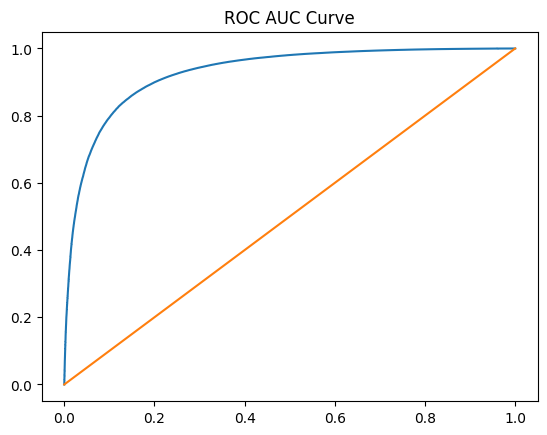

In [22]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve')

Сравним со скорами из бейзлайна. Бейзлайн: предсказываем все нулями

In [23]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.45179623078175707


Видим, что наша модель обгоняет бейзлайн по метрикам ROC AUC и Log Loss.

In [37]:
i = 7000
print(thresholds[i],fpr[i],tpr[i])
print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.9712546474213334 0.030646443008672218 0.5565540039362761
900.8532866190371 1618.6269081664577


In [28]:
print(clf.intercept_)
for keff in clf.coef_[0]:
    print(keff)
output_data = [clf.intercept_,clf.coef_[0]]
with open("output/keffs.txt", "w") as txt_file:
    for line in output_data:
        txt_file.write("".join(str(line)) + "\n")


[-4.9062716]
0.022771069259604534
0.7303604454182856
0.7999344076642922
0.6704078333952536
-0.00098613267721404
0.0018064328214384689
0.24807451822893636
2.404243100058059


In [ ]:
def answer(centrality,pt,ep,n0,disp,chi2,npe0,prob):
    ans = clf.coef_[0][0]*centrality+clf.coef_[0][1]*pt+clf.coef_[0][2]*ep+clf.coef_[0][3]*n0+\
        clf.coef_[0][4]*disp+clf.coef_[0][5]*chi2+clf.coef_[0][6]*npe0+clf.coef_[0][7]*prob

In [49]:
mycut, AIcut = 0 ,0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =0
for index, row in data0.iterrows():
    counter+=1
    if counter>10000: break
    print(row['pt'], row['phi0'])

0.6591796875 1.0
0.7431640625 1.0
0.437255859375 0.0
0.34814453125 1.0
1.1025390625 1.0
0.533203125 1.0
0.6025390625 1.0
0.7265625 1.0
0.798828125 1.0
0.85107421875 1.0
0.318603515625 1.0
0.90234375 1.0
0.61767578125 1.0
0.4111328125 1.0
0.468505859375 0.0
0.42578125 0.0
0.669921875 1.0
1.2587890625 1.0
0.484375 1.0
1.3896484375 1.0
1.3916015625 1.0
1.63671875 1.0
0.451171875 1.0
0.397705078125 1.0
0.58837890625 0.0
0.438232421875 1.0
0.380859375 1.0
0.68115234375 1.0
0.490966796875 1.0
0.42578125 0.0
0.8017578125 1.0
0.54052734375 1.0
0.82275390625 0.0
1.2939453125 1.0
0.5390625 1.0
1.111328125 1.0
0.45458984375 1.0
1.40625 1.0
0.400146484375 0.0
0.6533203125 0.0
0.623046875 1.0
1.1298828125 1.0
0.646484375 1.0
0.70654296875 1.0
0.52392578125 1.0
0.810546875 1.0
0.5048828125 1.0
1.1884765625 0.0
0.59326171875 1.0
0.52685546875 1.0
0.62841796875 1.0
2.169921875 1.0
0.4248046875 1.0
0.4443359375 1.0
1.234375 1.0
0.73291015625 1.0
0.59033203125 1.0
0.779296875 1.0
0.445556640625 0.0
0.57